# 레포트만들기

In [1]:
import math
import re
import time
from datetime import datetime, date

import requests
from bs4 import BeautifulSoup
from selenium import webdriver

from IPython.display import Image
import pandas as pd
import numpy as np

pd.set_option('display.max_columns', None)

from pykrx import stock
import FinanceDataReader as fdr
from pandas_datareader import data as pdr
import yfinance as yf
yf.pdr_override()
import FinanceDataReader as fdr
import finterstellar as fs


import talib.abstract as ta
from talib import MA_Type


import warnings
warnings.filterwarnings(action='ignore')

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
#-------------------- 차트 관련 속성 (한글처리, 그리드) -----------
#plt.rc('font', family='NanumGothicOTF') # For MacOS
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

pd.set_option('max_colwidth', None)
plt.rcParams['font.family']

findfont: Font family ['NanumBarunGothic'] not found. Falling back to DejaVu Sans.


['Malgun Gothic']

# 데이터 load

In [387]:
import pandas as pd
import numpy as np

송파df=pd.read_csv('./datasets/송파df.csv')

In [388]:
송파df.columns

Index(['회원일련번호값', '측정일련번호', '센터명', '연령대구분명', '측정장소구분명', '측정연령수', '입력구분명',
       '인증구분명', '측정일자', '성별구분코드', '신장(cm)', '체중(kg)', '체지방율(%)', '허리둘레(cm)',
       'BMI(kg/㎡)', '상대악력(%)', '교차윗몸일으키기(회)', '반복점프(회)', '왕복오래달리기(회)',
       '트레드밀출력(VO₂max)', '스텝검사출력(VO₂max)', '앉아윗몸앞으로굽히기(cm)', '10M_4회_왕복달리기(초)',
       '전신반응(초)', '제자리멀리뛰기(cm)', '성인체공시간(초)', '운동처방내용', '기존나이구간', '추가나이구간',
       'BMI_판정', '비만동반질환_위험도', '심폐지구력등급'],
      dtype='object')

## 인증기준

In [4]:
#측정기준 list

남19_24 = [62,47.6,62.6,55,16.1,9.9,0.301,229,0.605]
남25_29 = [54,44.8,62.4,51,14.9,10.3,0.302,223,0.591]
남30_34 = [49,42.9,62.6,47,14.2,10.6,0.304,219,0.583]
남35_39 = [45,41.8,62.1,45,14.0,10.9,0.311,214,0.581]
남40_44 = [42,40.9,62.8,44,14.2,11.0,0.320,209,0.547]
남45_49 = [40,40.1,62.0,41,13.6,11.3,0.331,202,0.524]

여19_24 = [30,36.8,46.8,36,19.7,12.3,0.332,162,0.479]
여25_29 = [28,36.0,47.0,33,18.5,12.7,0.343,156,0.466]
여30_34 = [26,34.8,49.6,31,18.2,12.9,0.347,154,0.464]
여35_39 = [25,34.2,47.5,31,18.9,13.0,0.348,155,0.453]
여40_44 = [24,33.8,47.1,30,18.8,13.1,0.345,153,0.442]
여45_49 = [23,33.0,46.2,28,18.9,13.4,0.350,148,0.431]

남_측정list = [남19_24,남25_29,남30_34,남35_39,남40_44,남45_49]
여_측정list = [여19_24,여25_29,여30_34,여35_39,여40_44,여45_49]

In [5]:
여성_인증기준 = pd.DataFrame(여_측정list)
여성_인증기준.rename(index = {0:'여19_24',1:'여25_29',2:'여30_34',3:'여35_39',4:'여40_44',5:'여45_49'},
               columns = {0:'20m_왕복오래달리기(회)',
                          1:'트레드밀/스텝검사(ml/kg/min)',
                          2:'상대악력(%)',
                          3:'교차윗몸일으키기(회)',
                          4:'앉아윗몸앞으로굽히기(cm)',
                          5:'10미터왕복달리기(초)',
                          6:'반응시간(초)',
                          7:'제자리멀리뛰기(cm)',
                          8:'체공시간(초)'} ,inplace = True)
여성_인증기준

,20m_왕복오래달리기(회),트레드밀/스텝검사(ml/kg/min),상대악력(%),교차윗몸일으키기(회),앉아윗몸앞으로굽히기(cm),10미터왕복달리기(초),반응시간(초),제자리멀리뛰기(cm),체공시간(초)
여19_24,30,36.8,46.8,36,19.7,12.3,0.332,162,0.479
여25_29,28,36.0,47.0,33,18.5,12.7,0.343,156,0.466
여30_34,26,34.8,49.6,31,18.2,12.9,0.347,154,0.464
여35_39,25,34.2,47.5,31,18.9,13.0,0.348,155,0.453
여40_44,24,33.8,47.1,30,18.8,13.1,0.345,153,0.442
여45_49,23,33.0,46.2,28,18.9,13.4,0.350,148,0.431


In [6]:
남성_인증기준 = pd.DataFrame(남_측정list)
남성_인증기준.rename(index = {0:'남19_24',1:'남25_29',2:'남30_34',3:'남35_39',4:'남40_44',5:'남45_49'},
               columns = {0:'20m_왕복오래달리기(회)',
                          1:'트레드밀/스텝검사(ml/kg/min)',
                          2:'상대악력(%)',
                          3:'교차윗몸일으키기(회)',
                          4:'앉아윗몸앞으로굽히기(cm)',
                          5:'10미터왕복달리기(초)',
                          6:'반응시간(초)',
                          7:'제자리멀리뛰기(cm)',
                          8:'체공시간(초)'} ,inplace = True)
남성_인증기준

,20m_왕복오래달리기(회),트레드밀/스텝검사(ml/kg/min),상대악력(%),교차윗몸일으키기(회),앉아윗몸앞으로굽히기(cm),10미터왕복달리기(초),반응시간(초),제자리멀리뛰기(cm),체공시간(초)
남19_24,62,47.6,62.6,55,16.1,9.9,0.301,229,0.605
남25_29,54,44.8,62.4,51,14.9,10.3,0.302,223,0.591
남30_34,49,42.9,62.6,47,14.2,10.6,0.304,219,0.583
남35_39,45,41.8,62.1,45,14.0,10.9,0.311,214,0.581
남40_44,42,40.9,62.8,44,14.2,11.0,0.320,209,0.547
남45_49,40,40.1,62.0,41,13.6,11.3,0.331,202,0.524


# 인코딩

In [7]:
송파df['성별구분코드']=송파df['성별구분코드'].transform(lambda x : x.replace(['M','F'],[0,1]))

# 나이 구간 나누기

In [8]:
송파20df=송파df[(송파df['측정연령수']>=20) &(송파df['측정연령수']<30)]
송파30df=송파df[(송파df['측정연령수']>=30) &(송파df['측정연령수']<40)]
송파40df=송파df[(송파df['측정연령수']>=40) &(송파df['측정연령수']<50)]

송파20df.shape,송파30df.shape,송파40df.shape

((14544, 32), (7940, 32), (6137, 32))

In [9]:
송파df['연령대구분명'].value_counts()

성인    30914
Name: 연령대구분명, dtype: int64

In [10]:
송파df=송파df[송파df['연령대구분명']=='성인']

In [11]:
# 송파df

송파df['기존나이구간'] = 0
for i in range(len(송파df)):
    if 송파df['측정연령수'].iloc[i] >= 30.0 and 송파df['측정연령수'].iloc[i] < 35.0 :
        송파df['기존나이구간'].iloc[i] = '30대초반'
    
    if 송파df['측정연령수'].iloc[i] >= 35.0 and 송파df['측정연령수'].iloc[i]<40.0 :
        송파df['기존나이구간'].iloc[i] = '30대후반'
        
    if 송파df['측정연령수'].iloc[i] >= 19.0 and 송파df['측정연령수'].iloc[i] < 25.0 :
        송파df['기존나이구간'].iloc[i] = '20대초반'
    
    if 송파df['측정연령수'].iloc[i] >= 25.0 and 송파df['측정연령수'].iloc[i]<30.0 :
        송파df['기존나이구간'].iloc[i] = '20대후반'
    
    if 송파df['측정연령수'].iloc[i] >= 40.0 and 송파df['측정연령수'].iloc[i] < 45.0 :
        송파df['기존나이구간'].iloc[i] = '40대초반'

    if 송파df['측정연령수'].iloc[i] >= 45.0 and 송파df['측정연령수'].iloc[i]<50.0 :
        송파df['기존나이구간'].iloc[i] = '40대후반'

In [12]:
송파df[송파df['측정연령수']==19].shape

(2293, 32)

In [13]:
송파df['기존나이구간'].value_counts()

20대초반    10786
20대후반     6051
30대초반     4193
30대후반     3747
40대초반     3132
40대후반     3005
Name: 기존나이구간, dtype: int64

In [14]:
idx=송파df[송파df['기존나이구간']==0].index.values
송파df=송파df.drop(idx,axis=0)

In [15]:
# 송파30df['기존나이구간'] = 0
# for i in range(len(송파30df)):
#     if 송파30df['측정연령수'].iloc[i] >= 30.0 and 송파30df['측정연령수'].iloc[i] < 35.0 :
#         송파30df['기존나이구간'].iloc[i] = '30대초반'
    
#     if 송파30df['측정연령수'].iloc[i] >= 35.0 and 송파30df['측정연령수'].iloc[i]<40.0 :
#         송파30df['기존나이구간'].iloc[i] = '30대후반'

In [16]:
송파df['추가나이구간'] = 0
for i in range(len(송파df)):
    if 송파df['측정연령수'].iloc[i] >=30 and 송파df['측정연령수'].iloc[i]<=32:
        송파df['추가나이구간'].iloc[i]='30대초반'
    if 송파df['측정연령수'].iloc[i] >=33 and 송파df['측정연령수'].iloc[i]<=36:
        송파df['추가나이구간'].iloc[i]='30대중반'
    if 송파df['측정연령수'].iloc[i] >=37 and 송파df['측정연령수'].iloc[i]<=39:
        송파df['추가나이구간'].iloc[i]='30대후반'
        
        
    if 송파df['측정연령수'].iloc[i] >=19 and 송파df['측정연령수'].iloc[i]<=22:
        송파df['추가나이구간'].iloc[i]='20대초반'
    if 송파df['측정연령수'].iloc[i] >=23 and 송파df['측정연령수'].iloc[i]<=26:
        송파df['추가나이구간'].iloc[i]='20대중반'
    if 송파df['측정연령수'].iloc[i] >=27 and 송파df['측정연령수'].iloc[i]<=29:
        송파df['추가나이구간'].iloc[i]='20대후반'
        
        
    if 송파df['측정연령수'].iloc[i] >=40 and 송파df['측정연령수'].iloc[i]<=42:
        송파df['추가나이구간'].iloc[i]='40대초반'
    if 송파df['측정연령수'].iloc[i] >=43 and 송파df['측정연령수'].iloc[i]<=46:
        송파df['추가나이구간'].iloc[i]='40대중반'
    if 송파df['측정연령수'].iloc[i] >=47 and 송파df['측정연령수'].iloc[i]<=49:
        송파df['추가나이구간'].iloc[i]='40대후반'


In [ ]:
19,23,27,30,33,37,40,43,47,50,53,57,60,63,67

In [17]:
송파df['추가나이구간'].value_counts().sort_index()

20대중반    5067
20대초반    8205
20대후반    3565
30대중반    3042
30대초반    2664
30대후반    2234
40대중반    2393
40대초반    1975
40대후반    1769
Name: 추가나이구간, dtype: int64

# 추가피쳐만들기

## BMI

- ref : https://www.hanam.go.kr/health/contents.do?key=8926

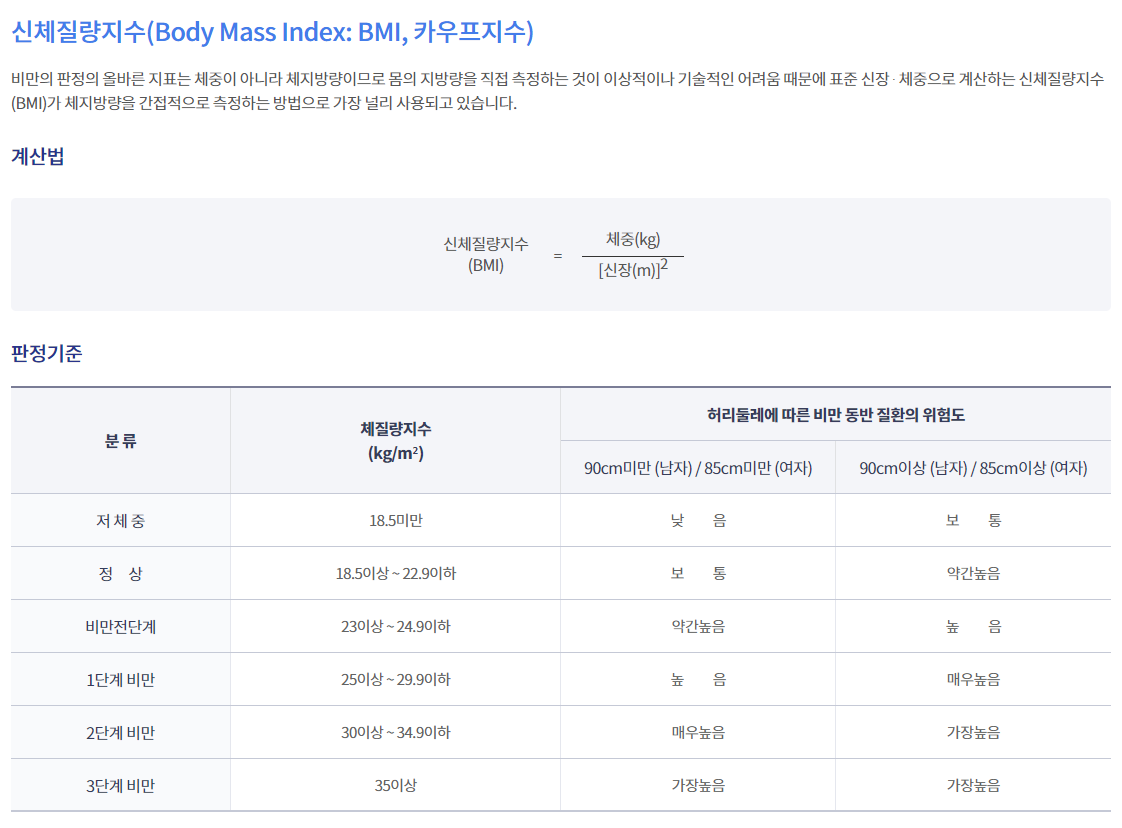

### BMI_판정

In [18]:
송파df['BMI_판정']=0

for i in range(len(송파df)):
    if 송파df['BMI(kg/㎡)'].iloc[i] < 18.5 :
        송파df['BMI_판정'].iloc[i]='저체중'
    if 송파df['BMI(kg/㎡)'].iloc[i] >=18.5 and 송파df['BMI(kg/㎡)'].iloc[i]<= 22.9:
        송파df['BMI_판정'].iloc[i]='정상'
    if 송파df['BMI(kg/㎡)'].iloc[i] >=23.0 and 송파df['BMI(kg/㎡)'].iloc[i]<= 24.9:
        송파df['BMI_판정'].iloc[i]='비만전단계'
    if 송파df['BMI(kg/㎡)'].iloc[i] >=25.0 and 송파df['BMI(kg/㎡)'].iloc[i]<= 29.9:
        송파df['BMI_판정'].iloc[i]='1단계비만'
    if 송파df['BMI(kg/㎡)'].iloc[i] >=30.0 and 송파df['BMI(kg/㎡)'].iloc[i]<= 34.9:
        송파df['BMI_판정'].iloc[i]='2단계비만'
    if 송파df['BMI(kg/㎡)'].iloc[i] >=35.0:
        송파df['BMI_판정'].iloc[i] = '3단계비만'

In [19]:
송파df['BMI_판정'].value_counts()

정상       12715
1단계비만     8276
비만전단계     7176
저체중       1416
2단계비만     1201
3단계비만      130
Name: BMI_판정, dtype: int64

### 비만동반질환_위험도

#### 허리둘레 0 값 채우기

In [20]:

from sklearn.model_selection import train_test_split, cross_val_score, cross_validate, GridSearchCV, KFold, StratifiedKFold
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_squared_log_error


from sklearn.ensemble     import RandomForestRegressor
from sklearn.tree         import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso
# ---- 추가 모델
from sklearn.ensemble     import AdaBoostRegressor, VotingRegressor
from xgboost              import XGBRegressor
from lightgbm             import LGBMRegressor



In [21]:
송파df.columns

Index(['회원일련번호값', '측정일련번호', '센터명', '연령대구분명', '측정장소구분명', '측정연령수', '입력구분명',
       '인증구분명', '측정일자', '성별구분코드', '신장(cm)', '체중(kg)', '체지방율(%)', '허리둘레(cm)',
       'BMI(kg/㎡)', '상대악력(%)', '교차윗몸일으키기(회)', '반복점프(회)', '왕복오래달리기(회)',
       '트레드밀출력(VO₂max)', '스텝검사출력(VO₂max)', '앉아윗몸앞으로굽히기(cm)', '10M_4회_왕복달리기(초)',
       '전신반응(초)', '제자리멀리뛰기(cm)', '성인체공시간(초)', '운동처방내용', '기존나이구간', '추가나이구간',
       'BMI_판정', '비만동반질환_위험도', '심폐지구력등급'],
      dtype='object')

In [22]:
송파df_cp=송파df.copy()
송파df_cp.columns

Index(['회원일련번호값', '측정일련번호', '센터명', '연령대구분명', '측정장소구분명', '측정연령수', '입력구분명',
       '인증구분명', '측정일자', '성별구분코드', '신장(cm)', '체중(kg)', '체지방율(%)', '허리둘레(cm)',
       'BMI(kg/㎡)', '상대악력(%)', '교차윗몸일으키기(회)', '반복점프(회)', '왕복오래달리기(회)',
       '트레드밀출력(VO₂max)', '스텝검사출력(VO₂max)', '앉아윗몸앞으로굽히기(cm)', '10M_4회_왕복달리기(초)',
       '전신반응(초)', '제자리멀리뛰기(cm)', '성인체공시간(초)', '운동처방내용', '기존나이구간', '추가나이구간',
       'BMI_판정', '비만동반질환_위험도', '심폐지구력등급'],
      dtype='object')

In [23]:
송파df_cp2=송파df_cp[['측정연령수','성별구분코드','신장(cm)', '체중(kg)', '체지방율(%)', '허리둘레(cm)',
       'BMI(kg/㎡)', '상대악력(%)', '교차윗몸일으키기(회)', '반복점프(회)', '왕복오래달리기(회)',
       '트레드밀출력(VO₂max)', '스텝검사출력(VO₂max)', '앉아윗몸앞으로굽히기(cm)', '10M_4회_왕복달리기(초)',
       '전신반응(초)', '제자리멀리뛰기(cm)', '성인체공시간(초)']]

In [24]:
송파df_cp2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30914 entries, 0 to 30913
Data columns (total 18 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   측정연령수            30914 non-null  float64
 1   성별구분코드           30914 non-null  int64  
 2   신장(cm)           30914 non-null  float64
 3   체중(kg)           30914 non-null  float64
 4   체지방율(%)          30914 non-null  float64
 5   허리둘레(cm)         30914 non-null  float64
 6   BMI(kg/㎡)        30914 non-null  float64
 7   상대악력(%)          30914 non-null  float64
 8   교차윗몸일으키기(회)      30914 non-null  float64
 9   반복점프(회)          30914 non-null  float64
 10  왕복오래달리기(회)       30914 non-null  float64
 11  트레드밀출력(VO₂max)   30914 non-null  float64
 12  스텝검사출력(VO₂max)   30914 non-null  float64
 13  앉아윗몸앞으로굽히기(cm)   30914 non-null  float64
 14  10M_4회_왕복달리기(초)  30914 non-null  float64
 15  전신반응(초)          30914 non-null  float64
 16  제자리멀리뛰기(cm)      30914 non-null  float64
 17  성인체공시간(초)   

In [25]:
# def my_fill_windspeed(df):
#     target  = df[['regcount','casual','registered', 'regdate']]
#     df = df.drop(['regcount','casual','registered','regdate'], axis=1)
    
df1   = 송파df_cp2[송파df_cp2['허리둘레(cm)'] != 0]
y_df1 = df1['허리둘레(cm)']
X_df1 = df1.drop('허리둘레(cm)', axis=1)

rf = RandomForestRegressor(random_state=11)  #RandomForestRegressor(random_state=11)
X_df1_8, X_df1_2, y_df1_8, y_df1_2 = train_test_split(X_df1, y_df1, test_size=0.2, random_state=11)
rf.fit(X_df1_8, y_df1_8)

pred = rf.predict(X_df1_2)
mse_score = mean_squared_error(y_df1_2, pred)
print("RMSE : ", np.sqrt(mse_score) )

# pd.concat([송파df, target], axis=1)

RMSE :  12.28120114880025


In [ ]:
df0 = 송파df_cp2[송파df_cp2['허리둘레(cm)'] == 0]
y_df0 = df0['허리둘레(cm)']
X_df0 = df0.drop('허리둘레(cm)', axis=1)
pred = rf.predict(X_df0)
widx = X_df0.index.values
송파df_cp2.loc[widx, '허리둘레(cm)'] = pred

In [ ]:
송파df_cp2[송파df_cp2['허리둘레(cm)']==0]

In [ ]:
송파df['허리둘레(cm)']=송파df_cp2['허리둘레(cm)']

In [ ]:
송파df['허리둘레(cm)'][송파df['허리둘레(cm)']!=0].shape,송파df.shape[0]

#### 계산하기

In [ ]:
# 송파df[(송파df['BMI_판정'] == '저체중')&( 송파df['허리둘레(cm)'] < 90)]

In [ ]:
송파df['비만동반질환_위험도']=0
for i in range(len(송파df)):
    if 송파df['성별구분코드'].iloc[i]==0  and  송파df['허리둘레(cm)'].iloc[i] < 90:
        if 송파df['BMI_판정'].iloc[i] == '저체중':
            송파df['비만동반질환_위험도'].iloc[i]='낮음'
        if 송파df['BMI_판정'].iloc[i] == '정상' :
            송파df['비만동반질환_위험도'].iloc[i]='보통'
        if 송파df['BMI_판정'].iloc[i] == '비만전단계':
            송파df['비만동반질환_위험도'].iloc[i]='약간높음'
        if 송파df['BMI_판정'].iloc[i] == '1단계비만':
            송파df['비만동반질환_위험도'].iloc[i]='높음'
        if 송파df['BMI_판정'].iloc[i] == '2단계비만':
            송파df['비만동반질환_위험도'].iloc[i]='매우높음'
        if 송파df['BMI_판정'].iloc[i] == '3단계비만':
            송파df['비만동반질환_위험도'].iloc[i]='가장높음'
            
    if 송파df['성별구분코드'].iloc[i]==0  and  송파df['허리둘레(cm)'].iloc[i] >= 90:
        if 송파df['BMI_판정'].iloc[i] == '저체중':
            송파df['비만동반질환_위험도'].iloc[i]='보통'
        if 송파df['BMI_판정'].iloc[i] == '정상' :
            송파df['비만동반질환_위험도'].iloc[i]='약간높음'
        if 송파df['BMI_판정'].iloc[i] == '비만전단계':
            송파df['비만동반질환_위험도'].iloc[i]='높음'
        if 송파df['BMI_판정'].iloc[i] == '1단계비만':
            송파df['비만동반질환_위험도'].iloc[i]='매우높음'
        if 송파df['BMI_판정'].iloc[i] == '2단계비만':
            송파df['비만동반질환_위험도'].iloc[i]='가장높음'
        if 송파df['BMI_판정'].iloc[i] == '3단계비만':
            송파df['비만동반질환_위험도'].iloc[i]='가장높음'
            
    if 송파df['성별구분코드'].iloc[i]==1 and  송파df['허리둘레(cm)'].iloc[i] < 85:
        if 송파df['BMI_판정'].iloc[i] == '저체중':
            송파df['비만동반질환_위험도'].iloc[i]='낮음'
        if 송파df['BMI_판정'].iloc[i] == '정상' :
            송파df['비만동반질환_위험도'].iloc[i]='보통'
        if 송파df['BMI_판정'].iloc[i] == '비만전단계':
            송파df['비만동반질환_위험도'].iloc[i]='약간높음'
        if 송파df['BMI_판정'].iloc[i] == '1단계비만':
            송파df['비만동반질환_위험도'].iloc[i]='높음'
        if 송파df['BMI_판정'].iloc[i] == '2단계비만':
            송파df['비만동반질환_위험도'].iloc[i]='매우높음'
        if 송파df['BMI_판정'].iloc[i] == '3단계비만':
            송파df['비만동반질환_위험도'].iloc[i]='가장높음'
            
    if 송파df['성별구분코드'].iloc[i]==1  and  송파df['허리둘레(cm)'].iloc[i] >= 85:
        if 송파df['BMI_판정'].iloc[i] == '저체중':
            송파df['비만동반질환_위험도'].iloc[i]='보통'
        if 송파df['BMI_판정'].iloc[i] == '정상' :
            송파df['비만동반질환_위험도'].iloc[i]='약간높음'
        if 송파df['BMI_판정'].iloc[i] == '비만전단계':
            송파df['비만동반질환_위험도'].iloc[i]='높음'
        if 송파df['BMI_판정'].iloc[i] == '1단계비만':
            송파df['비만동반질환_위험도'].iloc[i]='매우높음'
        if 송파df['BMI_판정'].iloc[i] == '2단계비만':
            송파df['비만동반질환_위험도'].iloc[i]='가장높음'
        if 송파df['BMI_판정'].iloc[i] == '3단계비만':
            송파df['비만동반질환_위험도'].iloc[i]='가장높음'

In [ ]:
송파df['비만동반질환_위험도'].value_counts()

## 스텝밀검사결과

- ref : https://m.blog.naver.com/PostView.naver?isHttpsRedirect=true&blogId=natboy0611&logNo=221407676871

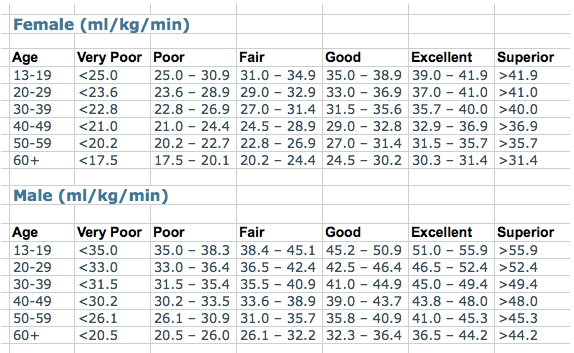

In [ ]:
# df_list=[송파30df,송파30_초df,송파30_중df,송파30_후df]
# for df in df_list:
송파df['심폐지구력등급']=0
for i in range(len(송파df)):
    if 송파df['측정연령수'].iloc[i]>=30.0 and 송파df['측정연령수'].iloc[i]<40.0:
        if 송파df['성별구분코드'].iloc[i]==1:
            if 송파df['스텝검사출력(VO₂max)'].iloc[i]<22.8:
                송파df['심폐지구력등급'].iloc[i]='very_poor'
            if 송파df['스텝검사출력(VO₂max)'].iloc[i]>=22.8 and 송파df['스텝검사출력(VO₂max)'].iloc[i]<27.0:
                송파df['심폐지구력등급'].iloc[i]='poor'
            if 송파df['스텝검사출력(VO₂max)'].iloc[i]>=27.0 and 송파df['스텝검사출력(VO₂max)'].iloc[i]<31.5:
                송파df['심폐지구력등급'].iloc[i]='fair'
            if 송파df['스텝검사출력(VO₂max)'].iloc[i]>=31.5 and 송파df['스텝검사출력(VO₂max)'].iloc[i]<35.7:
                송파df['심폐지구력등급'].iloc[i]='good'
            if 송파df['스텝검사출력(VO₂max)'].iloc[i]>=35.7 and 송파df['스텝검사출력(VO₂max)'].iloc[i]<=40.0:
                송파df['심폐지구력등급'].iloc[i]='excellent'
            if 송파df['스텝검사출력(VO₂max)'].iloc[i]>40.0:
                송파df['심폐지구력등급'].iloc[i]='superior'
        if 송파df['성별구분코드'].iloc[i]==0:
            if 송파df['스텝검사출력(VO₂max)'].iloc[i]<31.5:
                송파df['심폐지구력등급'].iloc[i]='very_poor'
            if 송파df['스텝검사출력(VO₂max)'].iloc[i]>=31.5 and 송파df['스텝검사출력(VO₂max)'].iloc[i]<35.5:
                송파df['심폐지구력등급'].iloc[i]='poor'
            if 송파df['스텝검사출력(VO₂max)'].iloc[i]>=35.5 and 송파df['스텝검사출력(VO₂max)'].iloc[i]<41.0:
                송파df['심폐지구력등급'].iloc[i]='fair'
            if 송파df['스텝검사출력(VO₂max)'].iloc[i]>=41.0 and 송파df['스텝검사출력(VO₂max)'].iloc[i]<45.0:
                송파df['심폐지구력등급'].iloc[i]='good'
            if 송파df['스텝검사출력(VO₂max)'].iloc[i]>=45.0 and 송파df['스텝검사출력(VO₂max)'].iloc[i]<=49.4:
                송파df['심폐지구력등급'].iloc[i]='excellent'
            if 송파df['스텝검사출력(VO₂max)'].iloc[i]>49.4:
                송파df['심폐지구력등급'].iloc[i]='superior'

In [ ]:
for i in range(len(송파df)):
    if 송파df['측정연령수'].iloc[i]>=19 and 송파df['측정연령수'].iloc[i]<30:
        if 송파df['성별구분코드'].iloc[i]==1:
            if 송파df['스텝검사출력(VO₂max)'].iloc[i]<23.6:
                송파df['심폐지구력등급'].iloc[i]='very_poor'
            if 송파df['스텝검사출력(VO₂max)'].iloc[i]>=23.6 and 송파df['스텝검사출력(VO₂max)'].iloc[i]<29.0:
                송파df['심폐지구력등급'].iloc[i]='poor'
            if 송파df['스텝검사출력(VO₂max)'].iloc[i]>=29.0 and 송파df['스텝검사출력(VO₂max)'].iloc[i]<33.0:
                송파df['심폐지구력등급'].iloc[i]='fair'
            if 송파df['스텝검사출력(VO₂max)'].iloc[i]>=33.0 and 송파df['스텝검사출력(VO₂max)'].iloc[i]<37.0:
                송파df['심폐지구력등급'].iloc[i]='good'
            if 송파df['스텝검사출력(VO₂max)'].iloc[i]>=37.0 and 송파df['스텝검사출력(VO₂max)'].iloc[i]<=41.0:
                송파df['심폐지구력등급'].iloc[i]='excellent'
            if 송파df['스텝검사출력(VO₂max)'].iloc[i]>41.0:
                송파df['심폐지구력등급'].iloc[i]='superior'
        if 송파df['성별구분코드'].iloc[i]==0:
            if 송파df['스텝검사출력(VO₂max)'].iloc[i]<33.0:
                송파df['심폐지구력등급'].iloc[i]='very_poor'
            if 송파df['스텝검사출력(VO₂max)'].iloc[i]>=33.0 and 송파df['스텝검사출력(VO₂max)'].iloc[i]<36.5:
                송파df['심폐지구력등급'].iloc[i]='poor'
            if 송파df['스텝검사출력(VO₂max)'].iloc[i]>=36.5 and 송파df['스텝검사출력(VO₂max)'].iloc[i]<42.5:
                송파df['심폐지구력등급'].iloc[i]='fair'
            if 송파df['스텝검사출력(VO₂max)'].iloc[i]>=42.5 and 송파df['스텝검사출력(VO₂max)'].iloc[i]<46.5:
                송파df['심폐지구력등급'].iloc[i]='good'
            if 송파df['스텝검사출력(VO₂max)'].iloc[i]>=46.5 and 송파df['스텝검사출력(VO₂max)'].iloc[i]<=52.4:
                송파df['심폐지구력등급'].iloc[i]='excellent'
            if 송파df['스텝검사출력(VO₂max)'].iloc[i]>52.4:
                송파df['심폐지구력등급'].iloc[i]='superior'

In [ ]:
for i in range(len(송파df)):
    if 송파df['측정연령수'].iloc[i]>=40 and 송파df['측정연령수'].iloc[i]<50:
        if 송파df['성별구분코드'].iloc[i]==1:
            if 송파df['스텝검사출력(VO₂max)'].iloc[i]<21.0:
                송파df['심폐지구력등급'].iloc[i]='very_poor'
            if 송파df['스텝검사출력(VO₂max)'].iloc[i]>=21.0 and 송파df['스텝검사출력(VO₂max)'].iloc[i]<24.5:
                송파df['심폐지구력등급'].iloc[i]='poor'
            if 송파df['스텝검사출력(VO₂max)'].iloc[i]>=24.5 and 송파df['스텝검사출력(VO₂max)'].iloc[i]<29.0:
                송파df['심폐지구력등급'].iloc[i]='fair'
            if 송파df['스텝검사출력(VO₂max)'].iloc[i]>=29.0 and 송파df['스텝검사출력(VO₂max)'].iloc[i]<32.9:
                송파df['심폐지구력등급'].iloc[i]='good'
            if 송파df['스텝검사출력(VO₂max)'].iloc[i]>=32.9 and 송파df['스텝검사출력(VO₂max)'].iloc[i]<=36.9:
                송파df['심폐지구력등급'].iloc[i]='excellent'
            if 송파df['스텝검사출력(VO₂max)'].iloc[i]>36.9:
                송파df['심폐지구력등급'].iloc[i]='superior'
        if 송파df['성별구분코드'].iloc[i]==0:
            if 송파df['스텝검사출력(VO₂max)'].iloc[i]<30.2:
                송파df['심폐지구력등급'].iloc[i]='very_poor'
            if 송파df['스텝검사출력(VO₂max)'].iloc[i]>=30.2 and 송파df['스텝검사출력(VO₂max)'].iloc[i]<33.6:
                송파df['심폐지구력등급'].iloc[i]='poor'
            if 송파df['스텝검사출력(VO₂max)'].iloc[i]>=33.6 and 송파df['스텝검사출력(VO₂max)'].iloc[i]<39.0:
                송파df['심폐지구력등급'].iloc[i]='fair'
            if 송파df['스텝검사출력(VO₂max)'].iloc[i]>=39.0 and 송파df['스텝검사출력(VO₂max)'].iloc[i]<43.8:
                송파df['심폐지구력등급'].iloc[i]='good'
            if 송파df['스텝검사출력(VO₂max)'].iloc[i]>=43.8 and 송파df['스텝검사출력(VO₂max)'].iloc[i]<=48.0:
                송파df['심폐지구력등급'].iloc[i]='excellent'
            if 송파df['스텝검사출력(VO₂max)'].iloc[i]>48.0:
                송파df['심폐지구력등급'].iloc[i]='superior'

In [ ]:
송파df['심폐지구력등급'].value_counts()

In [ ]:
송파df=송파df[['회원일련번호값','측정일자', '측정일련번호', '센터명','측정연령수','기존나이구간', '추가나이구간',
       '인증구분명',  '성별구분코드', '신장(cm)', '체중(kg)', '체지방율(%)', '허리둘레(cm)',
       'BMI(kg/㎡)','BMI_판정','비만동반질환_위험도',
       '상대악력(%)', '교차윗몸일으키기(회)', '반복점프(회)', '왕복오래달리기(회)',
       '트레드밀출력(VO₂max)', '스텝검사출력(VO₂max)','심폐지구력등급',
       '앉아윗몸앞으로굽히기(cm)', '10M_4회_왕복달리기(초)',
       '전신반응(초)', '제자리멀리뛰기(cm)', '성인체공시간(초)','운동처방내용']]

## 운동처방내용

### 국민체력100제공 추천 운동

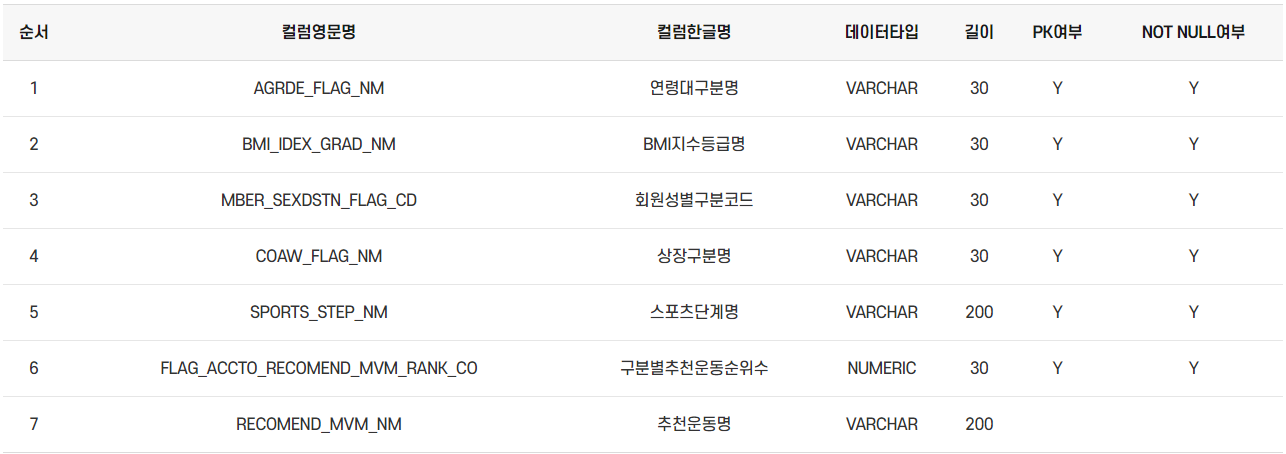

In [170]:
국민연령별추천운동정보=pd.read_csv('./datasets/기타/국민연령별추천운동정보.csv')
국민연령별추천운동정보.head(1)

,AGRDE_FLAG_NM,BMI_IDEX_GRAD_NM,MBER_SEXDSTN_FLAG_CD,COAW_FLAG_NM,SPORTS_STEP_NM,FLAG_ACCTO_RECOMEND_MVM_RANK_CO,RECOMEND_MVM_NM
0,10대,정상,F,참가증,본운동,1,줄넘기 운동


In [171]:
국민연령별추천운동정보=국민연령별추천운동정보[(국민연령별추천운동정보['AGRDE_FLAG_NM']=='20대')|(국민연령별추천운동정보['AGRDE_FLAG_NM']=='30대')|(국민연령별추천운동정보['AGRDE_FLAG_NM']=='40대')]
국민연령별추천운동정보.head()

,AGRDE_FLAG_NM,BMI_IDEX_GRAD_NM,MBER_SEXDSTN_FLAG_CD,COAW_FLAG_NM,SPORTS_STEP_NM,FLAG_ACCTO_RECOMEND_MVM_RANK_CO,RECOMEND_MVM_NM
720,20대,정상,F,참가증,본운동,1,윗몸올리기
721,20대,정상,F,참가증,본운동,2,엎드려 버티기
722,20대,정상,F,참가증,본운동,3,팔굽혀펴기
723,20대,정상,F,참가증,본운동,4,앉았다 일어서기
724,20대,정상,F,참가증,본운동,5,엎드려서 팔 다리 들기


In [172]:
국민연령별추천운동정보['RECOMEND_MVM_NM'].value_counts()

유산소 운동 전 동적 루틴 스트레칭       68
달리기                       59
버피운동                      58
앉았다 일어서기                  51
다리 벌려 앞으로 상체 숙이기          48
                          ..
의자에 앉아 몸통비틀기               1
한 발 앞굽이 팔 위로 뻗어 가슴 내밀기     1
다리굽혀 허리 비틀기                1
파워클린                       1
서서 균형잡으며 몸통 회전하기           1
Name: RECOMEND_MVM_NM, Length: 185, dtype: int64

In [173]:
운동_list=국민연령별추천운동정보['RECOMEND_MVM_NM'].unique()

value_10=[]

for 운동 in 운동_list:
    if 국민연령별추천운동정보[국민연령별추천운동정보['RECOMEND_MVM_NM']==운동].shape[0] >= 10:
        value_10.append(운동)
        

In [174]:
len(value_10)

76

In [175]:
df_list=[]
for 운동 in value_10:
    df=국민연령별추천운동정보[국민연령별추천운동정보['RECOMEND_MVM_NM']==운동]
    df_list.append(df)

국민연령별추천운동정보20_40=pd.concat(df_list)
국민연령별추천운동정보20_40=국민연령별추천운동정보20_40[국민연령별추천운동정보20_40['SPORTS_STEP_NM']=='본운동']

In [176]:
국민연령별추천운동정보20_30=국민연령별추천운동정보20_40[(국민연령별추천운동정보20_40['AGRDE_FLAG_NM']=='20대')|(국민연령별추천운동정보20_40['AGRDE_FLAG_NM']=='30대')]

In [180]:
국민연령별추천운동정보_recm_1=국민연령별추천운동정보20_30[국민연령별추천운동정보20_40['FLAG_ACCTO_RECOMEND_MVM_RANK_CO']==1]

In [391]:
국민연령별추천운동정보_recm_1[국민연령별추천운동정보_recm_1['AGRDE_FLAG_NM']=='30대'].sort_values('BMI_IDEX_GRAD_NM')

,AGRDE_FLAG_NM,BMI_IDEX_GRAD_NM,MBER_SEXDSTN_FLAG_CD,COAW_FLAG_NM,SPORTS_STEP_NM,FLAG_ACCTO_RECOMEND_MVM_RANK_CO,RECOMEND_MVM_NM
1815,30대,1단계비만,F,1등급,본운동,1,버피운동
1905,30대,1단계비만,M,3등급,본운동,1,엎드려 버티기
1890,30대,1단계비만,M,2등급,본운동,1,엎드려 버티기
1860,30대,1단계비만,M,참가증,본운동,1,엎드려 버티기
1845,30대,1단계비만,F,3등급,본운동,1,엎드려 버티기
1830,30대,1단계비만,F,2등급,본운동,1,엎드려 버티기
1800,30대,1단계비만,F,참가증,본운동,1,엎드려 버티기
1875,30대,1단계비만,M,1등급,본운동,1,버피운동
1935,30대,2단계비만,F,1등급,본운동,1,달리기
1920,30대,2단계비만,F,참가증,본운동,1,달리기


In [386]:
# 국민연령별추천운동정보_recm_1.to_csv('./datasets/국민연령별추천운동정보_recm_1.csv',index=False)

In [ ]:
# 국민연령별추천운동정보[(국민연령별추천운동정보['RECOMEND_MVM_NM'].str.contains('줄넘기'))&(국민연령별추천운동정보['AGRDE_FLAG_NM']=='20대')]

In [ ]:
# 국민연령별추천운동정보[['SPORTS_STEP_NM','FLAG_ACCTO_RECOMEND_MVM_RANK_CO','RECOMEND_MVM_NM']][(국민연령별추천운동정보['AGRDE_FLAG_NM']=='40대')&(국민연령별추천운동정보['BMI_IDEX_GRAD_NM']=='1단계비만')&
            # (국민연령별추천운동정보['MBER_SEXDSTN_FLAG_CD']=='M')&(국민연령별추천운동정보['COAW_FLAG_NM']=='참가증')]

In [ ]:
# 국민연령별추천운동정보['RECOMEND_MVM_NM'][(국민연령별추천운동정보['SPORTS_STEP_NM']=='본운동')].value_counts().values

### 운동처방내용분리

In [366]:
송파df=pd.read_csv('./datasets/송파df_up1.csv')
송파df.head(1)

,회원일련번호값,측정일자,측정일련번호,센터명,측정연령수,기존나이구간,추가나이구간,인증구분명,성별구분코드,신장(cm),체중(kg),체지방율(%),허리둘레(cm),BMI(kg/㎡),BMI_판정,비만동반질환_위험도,상대악력(%),교차윗몸일으키기(회),반복점프(회),왕복오래달리기(회),트레드밀출력(VO₂max),스텝검사출력(VO₂max),심폐지구력등급,앉아윗몸앞으로굽히기(cm),10M_4회_왕복달리기(초),전신반응(초),제자리멀리뛰기(cm),성인체공시간(초),운동처방내용
0,AAG5QWBWou0bMexvsnmPnULG,20200707,1,KSPO송파(출장B),43.0,40대초반,40대중반,참가증,0,176.7,83.2,27.1,93.834,26.6,1단계비만,매우높음,45.5,38.0,0.0,0.0,0.0,40.0,good,-5.7,11.3,0.0,201.0,0.0,"준비운동:조깅,고정식 트레드밀에서 걷기 / 본운동:요가 및 필라테스 루틴프로그램,요통을 위한 스트레칭1,요통을 위한 스트레칭2"


In [367]:
송파df['운동처방내용'].value_counts()

준비운동:전신 루틴 스트레칭                                                                                                                                                          3854
준비운동:상지 루틴 스트레칭,하지 루틴 스트레칭1 / 본운동:달리기,수영,실외 자전거타기,실내 자전거타기 / 마무리운동:넙다리 뒤쪽 스트레칭,넙다리 안쪽 스트레칭                                                                               1332
준비운동:상지 루틴 스트레칭,하지 루틴 스트레칭1 / 본운동:넙다리 뒤쪽 스트레칭,넙다리 안쪽 스트레칭                                                                                                                1237
준비운동:계단 올라갔다 내려오기                                                                                                                                                        1060
준비운동:자가근막이완술 루틴 스트레칭 / 본운동:넙다리 뒤쪽 스트레칭,넙다리 앞쪽 스트레칭,넙다리 안쪽 스트레칭,엉덩이 스트레칭,허리 스트레칭,배스트레칭,가슴/어깨 앞쪽 스트레칭,등/어깨 뒤쪽 스트레칭,목 스트레칭 / 마무리운동:전신 루틴 스트레칭                                962
                                                                                                                                  

In [368]:
송파df.shape

(30914, 29)

In [369]:
운동_list=[]
for i in range(len(송파df)):
    if len(송파df['운동처방내용'][i].split(' / '))>1:
        운동_list.append(송파df['운동처방내용'][i].split(' / ')[1])
    else :
        운동_list.append(송파df['운동처방내용'][i].split(' / ')[0])
송파df['운동처방내용_1차분리']=운동_list

In [370]:
송파df['운동처방내용_1차분리']

0                                                본운동:요가 및 필라테스  루틴프로그램,요통을 위한 스트레칭1,요통을 위한 스트레칭2
1                                                본운동:요가 및 필라테스  루틴프로그램,요통을 위한 스트레칭1,요통을 위한 스트레칭2
2                                                         본운동:실내 자전거타기,계단 올라갔다 내려오기,계단 뛰어 오르기,수영
3                                                         본운동:실내 자전거타기,계단 올라갔다 내려오기,계단 뛰어 오르기,수영
4                                                         본운동:실내 자전거타기,계단 올라갔다 내려오기,계단 뛰어 오르기,수영
                                                  ...                                           
30909                                                                          준비운동:계단 올라갔다 내려오기
30910                                                 준비운동:줄넘기 운동,앉았다 일어서기,엉덩이 늘리기,짐볼 운동  루틴프로그램
30911                                                 준비운동:줄넘기 운동,앉았다 일어서기,엉덩이 늘리기,짐볼 운동  루틴프로그램
30912                                                                          준비운동:계단 올라갔다 내려오기
30913    준비운동:윗몸올리기 ,엎드려 버티기,누

In [371]:
for i in range(len(송파df)):
    송파df['운동처방내용_1차분리'].iloc[i]=송파df['운동처방내용_1차분리'].iloc[i].split(',')[0]

In [372]:
for i in range(len(송파df)):
    try:
        송파df['운동처방내용_1차분리'].iloc[i]=송파df['운동처방내용_1차분리'].iloc[i].split(':')[1]
    except:
        송파df['운동처방내용_1차분리'].iloc[i]=송파df['운동처방내용_1차분리'].iloc[i]
송파df['운동처방내용_1차분리']

0        요가 및 필라테스  루틴프로그램
1        요가 및 필라테스  루틴프로그램
2                 실내 자전거타기
3                 실내 자전거타기
4                 실내 자전거타기
               ...        
30909         계단 올라갔다 내려오기
30910               줄넘기 운동
30911               줄넘기 운동
30912         계단 올라갔다 내려오기
30913               윗몸올리기 
Name: 운동처방내용_1차분리, Length: 30914, dtype: object

In [376]:
송파df['운동처방내용_1차분리']=송파df['운동처방내용_1차분리'].str.strip()

In [379]:
송파df=송파df.drop('운동처방내용',axis=1)

In [381]:
송파df=송파df.rename(columns={'운동처방내용_1차분리':'운동처방내용'})

In [383]:
송파df2030=송파df[(송파df['측정연령수']>=19)&(송파df['측정연령수']<=38)]
송파df2030['측정연령수'].value_counts()

20.0    2603
19.0    2293
21.0    1850
22.0    1459
23.0    1303
27.0    1289
24.0    1278
26.0    1253
25.0    1233
28.0    1221
29.0    1055
30.0     955
31.0     900
32.0     809
33.0     795
37.0     785
35.0     781
34.0     734
36.0     732
38.0     712
Name: 측정연령수, dtype: int64

In [385]:
# 송파df.to_csv('./datasets/송파df_up2.csv',index=False)

In [384]:
# 송파df2030.to_csv('./datasets/송파df2030.csv',index=False)